In [1]:
from functools import partial
import jax
from jax import grad, jit, lax, random, vmap
import jax.numpy as jnp
import jax.scipy as scipy
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["font.size"] = 24

## Fitting models to data

The gist of model is attempting to minimize the "difference" between data $y$ and a model $m$ that depends parameters $\theta$. Here,  "difference" can mean several different| things like mean squared error, $L_{1}$ error, cross binary entropy, negative loglikelihood, KL divergence, the evidence lower bound. 

## Minimizing mean square error

We'll begin with the simple example of minimizing the least squares error of the following model

\begin{align}
m_\beta(x) &= \beta_{0} + \beta_{1} x,  \quad \beta = (\beta_{0}, \beta_{1})\\
     &= X \cdot \beta, \quad\quad X = (1, x)
\end{align}

given inputs $\vec{x} = (x_{1}, \ldots, x_{N})$ and outputs $\vec{y} = (y_{1}, \ldots, y_{N})$. We can write this as a problem in terms of the mean squared error

$$
\text{MSE}( m_\beta(\vec{x}), \vec{y}) = \frac{1}{N} \sum_{i=1}^{N} \Big(m_\beta(x_{i}) - y_{i} \Big)^2.
$$


For this problem, finding the best-fit parameters means solving the following:

$$
\beta^{*} = \text{arg min}_{\beta \in \mathbb{R}^2} \Big[ \text{MSE}( m_\beta(\vec{x}), \vec{y}) \Big].
$$

Let's start by generating some data.

In [3]:
## Linear models
def linear_expectation(X, β):
    return jnp.dot(X, β)

def simulate_linear_data(X, β, σ, key = None):
    if key is None:
        key = random.PRNGKey(SEED)
        
    key, subkey = random.split(key)
    EY = jnp.dot(X, β)
    return EY + σ*random.normal(subkey, EY.shape)

SEED = 11 * 2 * 2021
key = random.PRNGKey(SEED)
key, subkey = random.split(key)

In [4]:
X = jnp.stack([jnp.repeat(1, 100), 
               jnp.array([t for t in range(100)])]).T # Feature matrix
β = jnp.array([2.0, 0.1]) # True parameters
σ = 1.0 # Noise level

Y = simulate_linear_data(X, β, σ, key = key) # Simulated data

Text(0, 0.5, 'Brownies consumed')

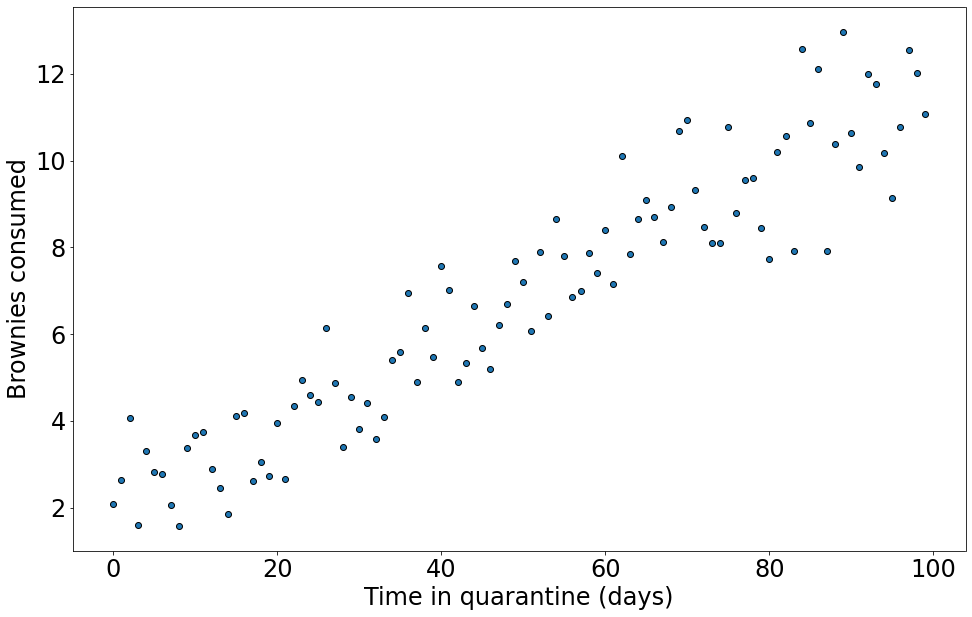

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 
ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

## Linear Regression admits a closed form solution

In the case of linear regression, we can find a closed form solution to minimize the least squares error using the pseudo-inverse of the feature matrix $X$.

In [6]:
@jit
def solve_least_squares(X, Y):
    β_hat = jnp.linalg.lstsq(X, Y)[0] # Get least squares solution
    Y_hat = jnp.dot(X, β_hat) # Get predicted Y
    return β_hat, Y_hat

β_hat, Y_hat = solve_least_squares(X,Y)

Text(0, 0.5, 'Brownies consumed')

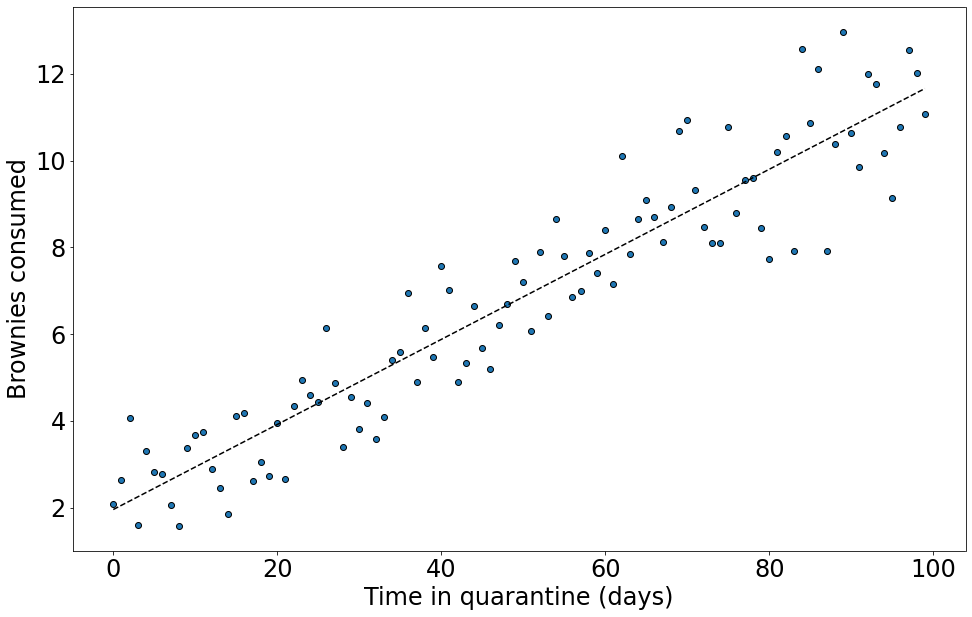

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, edgecolors='k')
ax.plot(X[:,1], Y_hat, color = "k", linestyle = "--")
ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

## Linear regression isn't limited to just lines 

In [8]:
# Building a trig basis with vmap
def trig_basis(x, j, L):
    t = 2 * jnp.pi * j / L * x
    return jnp.array([jnp.cos(t), jnp.sin(t)])

trig_basis_v = vmap(trig_basis, in_axes = (0, None, None))
trig_basis_v = vmap(trig_basis_v, in_axes = (None, 0, None))

@partial(jit, static_argnums = (1,2))
def trig_basis(x, period, K):
    X = trig_basis_v(x, jnp.arange(1,K+1), period)
    return jnp.concatenate(X, 1)

In [9]:
T = jnp.arange(365*5)
X_trig = trig_basis(T, 365, 4)
X_trig = jnp.column_stack([X_trig, jnp.repeat(1., X_trig.shape[0])]) # Create Trig basis with intercept

β_trig = random.normal(random.PRNGKey(SEED), (X_trig.shape[1]-1,)) # Generate parameters
β_trig = jnp.append(β_trig, 20.) # Add fixed intercept
Y_trig = simulate_linear_data(X_trig, β_trig, 1.)

Text(0, 0.5, 'Daily Mariah Carey Listens')

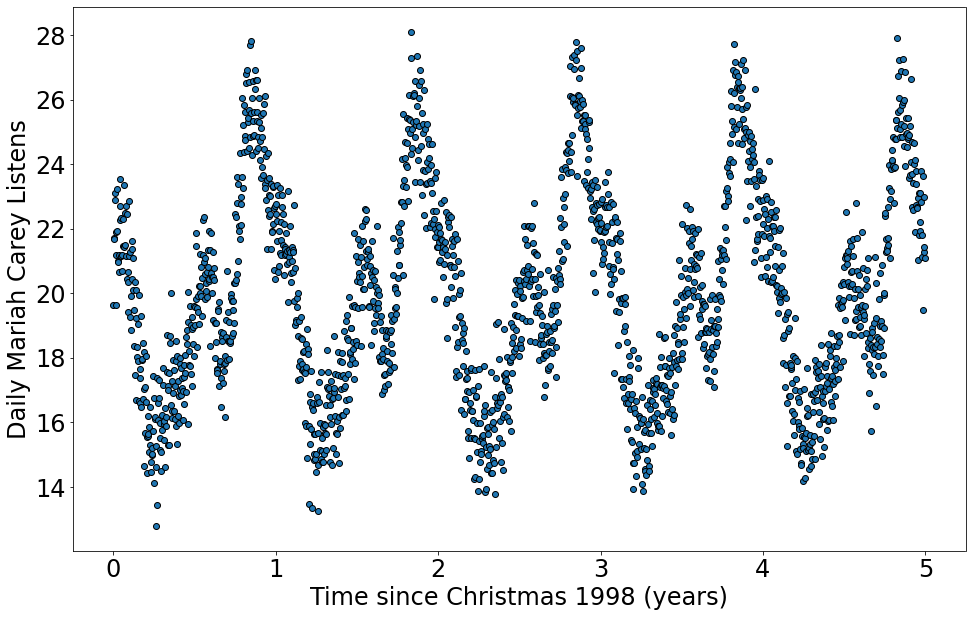

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(T / 365, Y_trig, edgecolors='k')
ax.set_xlabel("Time since Christmas 1998 (years)")
ax.set_ylabel("Daily Mariah Carey Listens")

Text(0, 0.5, 'Daily Mariah Carey Listens')

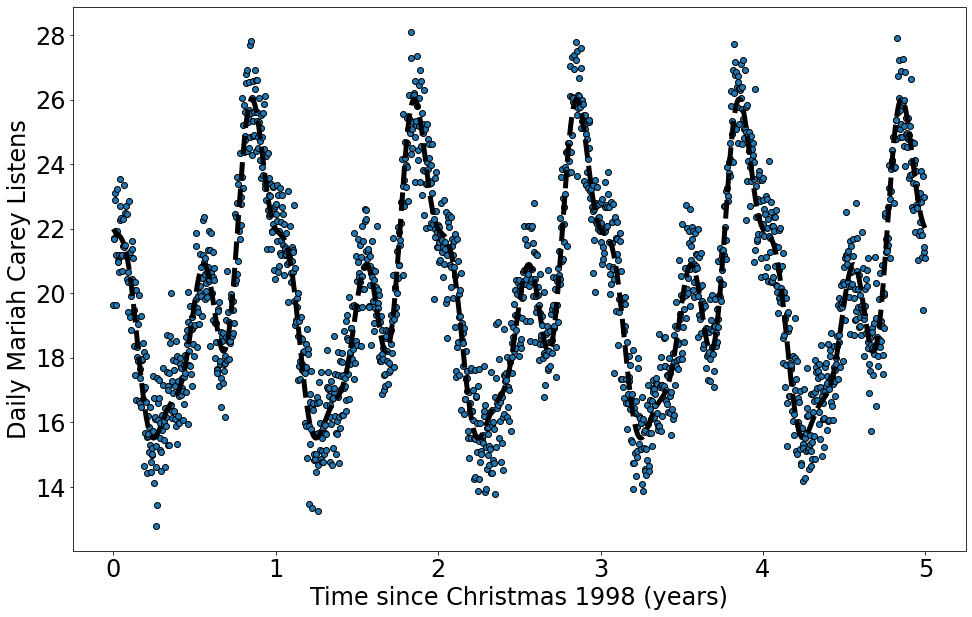

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

β_trig_hat, Y_trig_hat = solve_least_squares(X_trig,Y_trig)


ax.scatter(T / 365, Y_trig, edgecolors='k')
ax.plot(T / 365, Y_trig_hat, color = "k", linestyle = "--", linewidth=5)

ax.set_xlabel("Time since Christmas 1998 (years)")
ax.set_ylabel("Daily Mariah Carey Listens")

## There's not always an analytic solution

We'll rephrase this as optimization problem. Oftentimes, we'll use some kind of optimization routine.
$$
\theta^* = \text{arg min}_{\theta} \Big[ \text{MSE}( \hat{y}(\theta), y) \Big]
$$

Common ones are things like gradient descent, but let's not get too deep into details. Languages like python, matlab, R will typically have their own optimizers, so you can look up details on your own.

Also, autodifferentiation makes this a lot easier as well.


In [12]:
def mean_square_error(Y_hat, Y):
    return jnp.power(Y_hat - Y, 2).mean()

def loss(β, X, Y):
    Y_hat = jnp.dot(X, β)
    return mean_square_error(Y_hat, Y)

### Gradient descent

You can implement this yourself, but you're better off just using built-in routines which have been optimized by someone who cares more than you.

In [13]:
## Gradient Descent
grad_loss = jit(grad(loss, argnums = 0))

@jit
def gd_step(β, X, Y, lr=1e-3):
    β_grad = grad_loss(β, X, Y)
    return β - lr*β_grad
    
def gradient_descent(β0, X, Y, lr=1e-2, n_steps=1000, rel_tol=1e-5):
    β = β0
    for it in range(n_steps):
        new_β = gd_step(β, X, Y, lr)
        
        # Check for convergence
        rel_err = jnp.sqrt(mean_square_error(β, new_β))
        if rel_err < rel_tol:
            print(f"Converged: Relative Error = {rel_err}")
            break
        # Update parameters
        β = new_β
    return β

In [14]:
β0 = jnp.repeat(0.01,  X_trig.shape[1])
β_trig_hat_gd = gradient_descent(β0, X_trig, Y_trig)

Converged: Relative Error = 9.98419363895664e-06


In [15]:
β_trig_hat

DeviceArray([ 2.2148979 , -2.9080584 ,  1.314451  , -0.86984986,
             -1.0643209 , -0.2050023 , -0.42868543,  0.9501374 ,
             19.964056  ], dtype=float32)

In [16]:
β_trig_hat_gd

DeviceArray([ 2.2133415 , -2.9059951 ,  1.3135293 , -0.869228  ,
             -1.0635623 , -0.20485093, -0.42837748,  0.9494736 ,
             19.964014  ], dtype=float32, weak_type=True)

Text(0, 0.5, 'Daily Mariah Carey Listens')

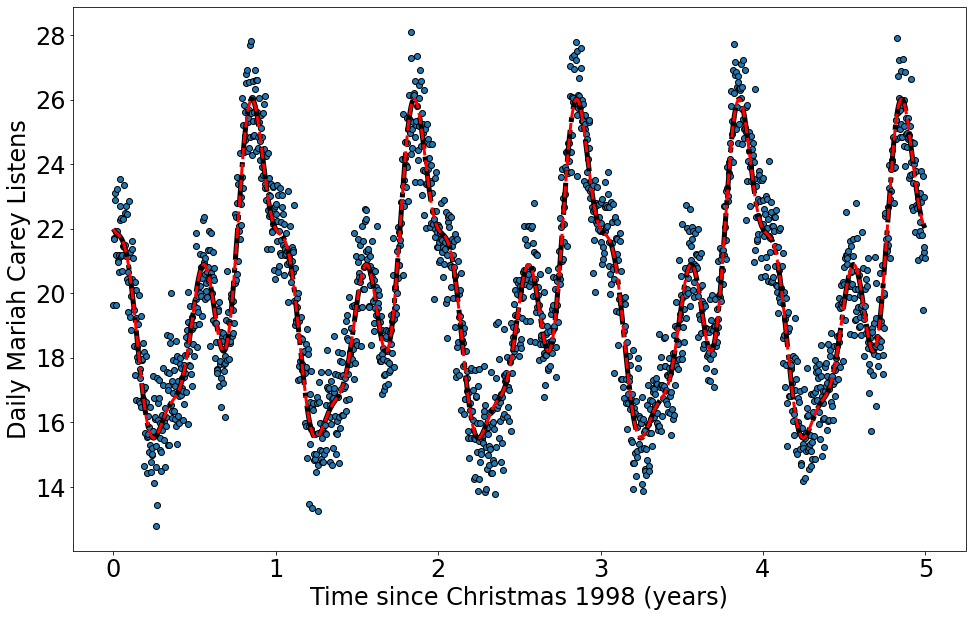

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(T / 365, Y_trig, edgecolors='k')
ax.plot(T / 365, Y_trig_hat, 
        color = "k", linestyle = "-.", linewidth=5)
ax.plot(T / 365, jnp.dot(X_trig, β_trig_hat_gd), 
                                   color = "r", linestyle = "--", linewidth=3)

ax.set_xlabel("Time since Christmas 1998 (years)")
ax.set_ylabel("Daily Mariah Carey Listens")

### Using built in optimization routines

In [18]:
from jax.scipy.optimize import minimize

In [19]:
obj = lambda β : loss(β, X_trig, Y_trig)
β0 = jnp.repeat(0.01,  X_trig.shape[1])
opt = minimize(obj, β0, method = "BFGS")
opt.x

DeviceArray([ 2.2148962, -2.9080546,  1.3144498, -0.8698489, -1.0643206,
             -0.2050026, -0.428687 ,  0.9501371, 19.96406  ],            dtype=float32)

Text(0, 0.5, 'Daily Mariah Carey Listens')

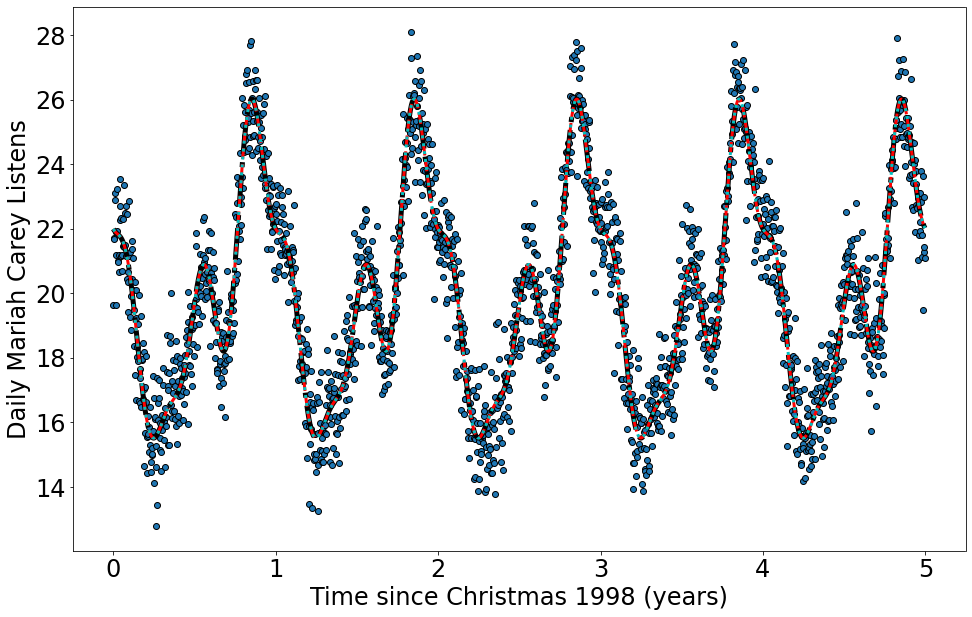

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(T / 365, Y_trig, edgecolors='k')
ax.plot(T / 365, Y_trig_hat, 
        color = "k", linestyle = "-.", linewidth=5)
ax.plot(T / 365, jnp.dot(X_trig, β_trig_hat_gd), 
                                   color = "r", linestyle = "--", linewidth=3)
ax.plot(T / 365, jnp.dot(X_trig, opt.x), 
                                   color = "c", linestyle = ":", linewidth=3)
ax.set_xlabel("Time since Christmas 1998 (years)")
ax.set_ylabel("Daily Mariah Carey Listens")

## Regularization

We can also generalize this a bit and add extra components to our objective. For example, let's suppose we want to shrink our parameters to 0, we then have that

$$
\theta^* = \text{arg min}_{\theta} \Big[ \text{MSE}(\hat{Y}(\theta), Y) + \text{Reg}(\theta) \Big].
$$

There are various common models with this fomulation. These are models like LASSO regression, Ridge Regression, among others which you can find built-in routines for in SciKitLearn.

## More complex models

We focused on linear models, but this is something more general. In general, we can consider models of the form

$$
\theta^* = \text{arg min}_{\theta} \Big[ L(\hat{Y}(\theta), Y, \theta) \Big],
$$

where $L$ is a general loss function which depends on our parameters, our estimate, and the original data.

Let's try this with an ODE model.

In [21]:
from jax.experimental.ode import odeint

In [22]:
@jit
def LV_step(u, t, θ):
    x, y =  (u[0], u[1])
    α, β, γ, δ = (θ[0], θ[1], θ[2], θ[3])
    
    dx_dt = (α - β*y)*x
    dy_dt = (-γ + δ*x)*y
    return jnp.stack([dx_dt, dy_dt])
    
true_θ = (0.55, 0.028, 0.8, 0.024)    
u0 = jnp.array([30., 4.])
t = jnp.arange(20.)

In [23]:
Y = odeint(LV_step, u0, t, true_θ) 

# Save Pois for likelihood stuff
#key = random.PRNGKey(SEED)
#key, subkey = random.split(key)
#Y = random.poisson(key, true_Y, shape = true_Y.shape)

Text(0, 0.5, 'Observed Hares (blue) and Lynx (yellow)')

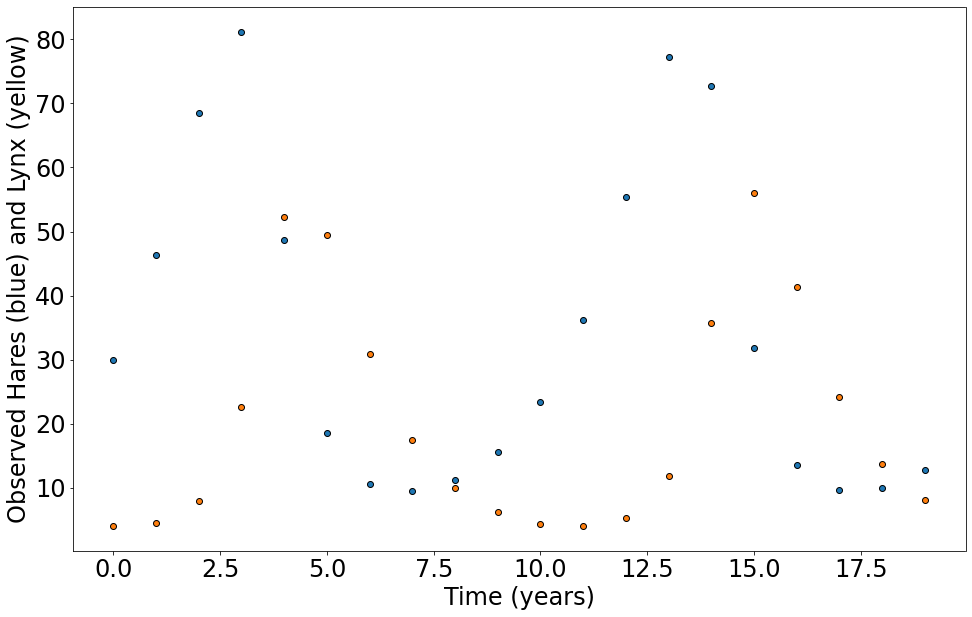

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(t, Y[:,0], edgecolors='k')
ax.scatter(t, Y[:,1], edgecolors='k')
ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")

# Fitting the ODE model

I'll be using JAX and it's optimizers, but there's also a non-jax scipy function called curve_fit that achieves basically the same thing. It finds the least square solution by default.

In [25]:
from scipy.integrate import odeint 
from scipy.optimize import curve_fit

In [26]:
def LV_step(u, t, θ):
    x, y =  (u[0], u[1])
    α, β, γ, δ = (θ[0], θ[1], θ[2], θ[3])
    
    dx_dt = (α - β*y)*x
    dy_dt = (-γ + δ*x)*y
    return [dx_dt, dy_dt]

def run_LV(t, α, β, γ, δ):
    θ_ = [α, β, γ, δ]
    u0_ = [30., 4.]
    return odeint(LV_step, u0_, t, args = (θ_,)).ravel()

In [27]:
θ0 = [1.0, 0.05, 1.0, 0.05]
θ_hat, cov = curve_fit(run_LV, xdata=t, ydata=Y.ravel(), p0=θ0)

/Users/marlinfiggins/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [28]:
print(cov)

[[ 1.17674844e-14  7.54044985e-16 -1.79797260e-14 -4.97879240e-16]
 [ 7.54044985e-16  6.57405795e-17 -1.22942890e-15 -3.48120452e-17]
 [-1.79797260e-14 -1.22942890e-15  3.05437986e-14  7.50981169e-16]
 [-4.97879240e-16 -3.48120452e-17  7.50981169e-16  2.49398201e-17]]


In [29]:
θ_hat

array([0.55000008, 0.02800001, 0.80000017, 0.024     ])

In [30]:
true_θ

(0.55, 0.028, 0.8, 0.024)

Text(0, 0.5, 'Observed Hares (blue) and Lynx (yellow)')

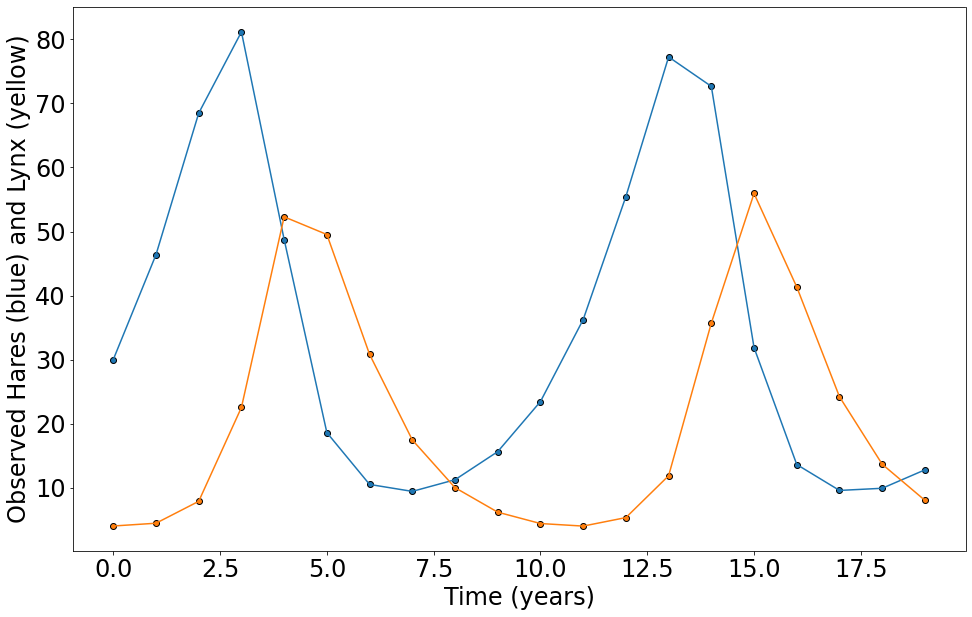

In [31]:
Y_hat = odeint(LV_step, u0, t, args = (θ_hat,)) 
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(t, Y[:,0], edgecolors='k')
ax.scatter(t, Y[:,1], edgecolors='k')

ax.plot(t, Y_hat)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")

## Using JAX

### Using built-in minimize

In [32]:
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.scipy.optimize import minimize

In [33]:
@jit
def LV_step(u, t, θ):
    x, y =  (u[0], u[1])
    α, β, γ, δ = (θ[0], θ[1], θ[2], θ[3])
    
    dx_dt = (α - β*y)*x
    dy_dt = (-γ + δ*x)*y
    return jnp.stack([dx_dt, dy_dt])

@jit
def loss_LV(θ, u0, t, Y):
    Y_hat = odeint(LV_step, u0, t, θ) 
    return mean_square_error(Y_hat, Y)

@jit
def LV_obj(θ):
    return loss_LV(θ, u0, t, Y)
    
grad_LV = grad(loss_LV, argnums=0) # Get gradient

Note about transfoming parameters to meet constraints.

In [34]:
lnθ0 = jnp.array([0.0, -5., 0.0, -5.]) 
obj = lambda lnθ: loss_LV(jnp.exp(lnθ), u0, t, Y)
opt = minimize(obj, lnθ0, method = "BFGS")
θ_hat = jnp.exp(opt.x)

In [35]:
θ_hat

DeviceArray([0.5500004 , 0.02800005, 0.8       , 0.02399998], dtype=float32)

In [36]:
true_θ

(0.55, 0.028, 0.8, 0.024)

Text(0, 0.5, 'Observed Hares (blue) and Lynx (yellow)')

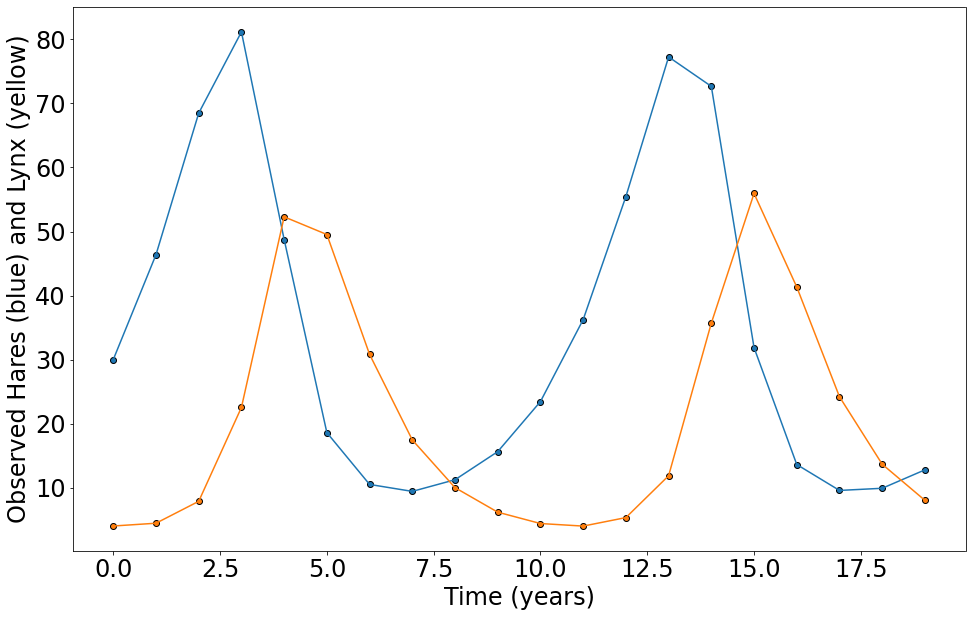

In [37]:
Y_hat = odeint(LV_step, u0, t, θ_hat)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(t, Y[:,0], edgecolors='k')
ax.scatter(t, Y[:,1], edgecolors='k')

ax.plot(t, Y_hat)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")

### Implementing optimization by hand

In [38]:
@partial(jit, static_argnums = (4))
def run_loop(opt_state, u0, t, Y, num_epochs):
    @jit
    def _update_θ(opt_state, iters):
        grads = grad_LV(jnp.exp(get_params(opt_state)), u0, t, Y)
        opt_state = opt_update(iters, grads, opt_state)
        return opt_state, None

    opt_state, _ = jax.lax.scan(_update_θ, init = opt_state, xs = jnp.arange(num_epochs))
    return opt_state

# Defining ADAM optimzer
lr = 1e-3
opt_init, opt_update, get_params = optimizers.adam(lr)

# Initalize state
lnθ0 = jnp.array([0.0, -5., 0.0, -5.])
opt_state = opt_init(lnθ0)
opt_state = run_loop(opt_state, u0, t, Y, num_epochs=20_000)

In [39]:
θ_hat = jnp.exp(get_params(opt_state))
Y_hat = odeint(LV_step, u0, t, θ_hat) 

In [40]:
θ_hat

DeviceArray([0.5499903 , 0.02800001, 0.7999877 , 0.024     ], dtype=float32)

In [41]:
true_θ

(0.55, 0.028, 0.8, 0.024)

Text(0, 0.5, 'Observed Hares (blue) and Lynx (yellow)')

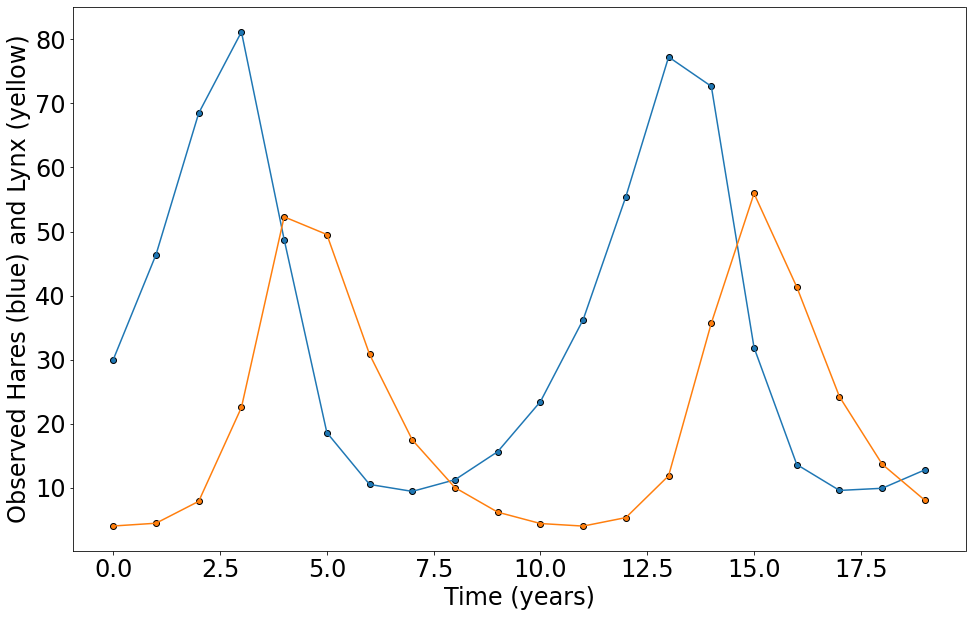

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(t, Y[:,0], edgecolors='k')
ax.scatter(t, Y[:,1], edgecolors='k')

ax.plot(t, Y_hat)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Observed Hares (blue) and Lynx (yellow)")

## Takeaways

- Lots of "curve fitting" problems can be rephrased as an optimization problem.
- Sometimes, there are analytic solutions to these curve fitting problems.
- When there is no analytic solution, we can often fall back on built-in optimization routines or well-established algorithms.
- Regularization can be useful for constraining models and their parameters.
    - In particular, $L_{1}$ norms can be used to induce sparsity in parameters.

## References

### Books

The Elements of Statistical Learning: Data Mining, Inference, and Prediction.
- This book has a lot on inference, prediction.
- Holy grail book in my opinion, but can be terse.


An Introduction to Statistical Learning: With Applications in R
- Easier than the above, but also very good!

[Python data science handbook: Chapter on Linear regression](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)

### Blog posts

[Linear regression with basis functions and regularization](https://towardsdatascience.com/how-to-improve-your-linear-regression-with-basis-functions-and-regularization-8a6fcebdc11c)

[Modeling Data and Curve Fitting — Non-Linear Least-Squares Minimization and Curve-Fitting for Python](https://lmfit.github.io/lmfit-py/model.html)

### Software

[scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

